In [1]:
import torch
import torch.jit as jit
import numpy as np
import PIL.Image
import json

from IPython.display import Image, display

In [2]:
with open('./imagenet_classes.json', mode='rt') as f:
    CLASS_DICT = json.load(f)
    
IMAGENET_MEAN = np.array([[[0.485, 0.456, 0.406]]], dtype=np.float32)
IMAGENET_STD = np.array([[[0.229, 0.224, 0.225]]], dtype=np.float32)

def predict_imagenet(net, image_file):
    # Load image and resize
    image = PIL.Image.open(image_file).resize((244, 244))
    # Convert to numpy and normalize
    image = np.array(image, dtype=np.float32) / 255.
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    # Convert to PyTorch and make channel first
    image = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2)
    # Predict top class
    logits = net(image)
    class_idx = logits.squeeze(0).argmax().item()
    # Output predictions
    print('It is a %s.' % CLASS_DICT[str(class_idx)])
    display(Image(filename=image_file))

Loading the traced network from disk. The weights are mapped the CPU and not to the device saved from. This behaviour is different from torch.load().

It is a Persian cat.


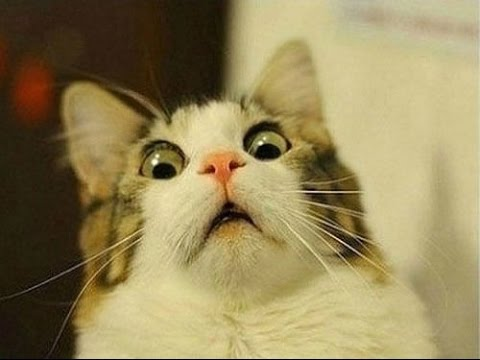

https://i.ytimg.com/vi/2fb-g_V-UT4/hqdefault.jpg


In [3]:
net = jit.load('./model.pth')
predict_imagenet(net, './whats_this.jpg')
print('https://i.ytimg.com/vi/2fb-g_V-UT4/hqdefault.jpg')

When printing the network, we can see that submodules have no name and no parameters displayed. Other than from the untraced network print, we cannot infer anything from this print.

In [4]:
print(net)

ScriptModule(
  (features): ScriptModule(
    (0): ScriptModule()
    (1): ScriptModule()
    (2): ScriptModule()
    (3): ScriptModule()
    (4): ScriptModule()
    (5): ScriptModule()
    (6): ScriptModule()
    (7): ScriptModule()
    (8): ScriptModule()
    (9): ScriptModule()
    (10): ScriptModule()
    (11): ScriptModule()
    (12): ScriptModule()
  )
  (avgpool): ScriptModule()
  (classifier): ScriptModule(
    (0): ScriptModule()
    (1): ScriptModule()
    (2): ScriptModule()
    (3): ScriptModule()
    (4): ScriptModule()
    (5): ScriptModule()
    (6): ScriptModule()
  )
)


But let's have a look at the first module to see how much we can find out. The dir() function reveals all python functions of an object. Since version 1.2 the ScriptModule has all the function of a normal nn.Module. Before the dir() function failed actually. One function is most interesting: code. Could this show us the code of our network?

In [5]:
dir(net.features._modules['0'])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_c',
 '_constants_set',
 '_construct',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_methods',
 '_modules',
 '_named_members',
 '_overloads',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'bias',
 'buffers',
 'children',
 'code',
 'copy',
 'cpu',
 'cuda',
 'define',
 'double',


This throws an error. Seems that the output of the code() function is not retained when saving and reloading the traced network. When trying to access this function in the notebook where the network was traced, we can actually see the code. Same goes for the graph() function, which shows us the computation as aten operators.

In [6]:
net.features._modules['0'].code

AttributeError: 'ScriptModule' object has no attribute 'code'

Next let's look at the member variables. The var() function will expose them for us. We can see a lot of dictionaries, of which only five seem to hold something. We will check them one by one.

In [7]:
vars(net.features._modules['0'])

{'_c': <torch._C.ScriptModule at 0x27a3b25c030>,
 '_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x27a3cb31c18>,
 '_parameters': <torch.jit.OrderedParameterDict at 0x27a3cf5d0f0>,
 '_buffers': <torch.jit.OrderedBufferDict at 0x27a3cf5d048>,
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': <torch.jit.OrderedModuleDict at 0x27a3cf5d160>,
 'training': True}

In [8]:
print(net.features._modules['0']._modules.keys())

[]


In [9]:
print(net.features._modules['0']._buffers.keys())

[]


This dictionary seems to hold the weights and the bias of the module. So it's probably a convolution or a dense layer.

In [10]:
print(net.features._modules['0']._parameters.keys())

['weight', 'bias']


From the shape of the weights we can conclude that this module is probably a convolution layer with a 11x11 kernel, 3 input channels and 64 output channels. We still know nothing about the stride, dilation or if it is a transposed convolution.

In [11]:
print(net.features._modules['0']._parameters['weight'].shape)

torch.Size([64, 3, 11, 11])


# To the Debugger!

Descending into the code with our trusty debugger finally reveals the source code of our network. It was converted to TorchScript, but is still pretty readable. We now know everything there is to know about the architecture of our network.

In conclusion, we can say that the JIT hides the code of your net better than exporting it conventionally. To a determined person it is still no problem to retrieve it, though.

# But what about runtime?

Runtime of the untraced net in seconds (CPU):

In [14]:
import torchvision

untraced_net = torchvision.models.alexnet(pretrained=True)
x = torch.randn(16, 3, 244, 244)
%timeit -n 100 untraced_net(x)

960 ms ± 44.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Runtime of the traced net in seconds (GPU):

In [15]:
%timeit -n 100 net(x)

980 ms ± 89.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
